# LSTM with Residual Analysis and Metrics Calculation


In [450]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm import tqdm

In [451]:
df = pd.read_csv('data/us_change.csv')
df.head()

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1


In [452]:
# Normalize the dataset for LSTM
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["Consumption", "Income", "Production", "Savings", "Unemployment"]])
df_scaled = pd.DataFrame(df_scaled, columns=["Consumption", "Income", "Production", "Savings", "Unemployment"])
df_scaled["Quarter"] = df["Quarter"]

In [453]:
# Prepare time series data for LSTM (sliding window approach)
def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i : i + seq_length, :]
        seq_y = data[i + seq_length, target_column]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [454]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0)  # Add dropout
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Apply dropout at inference
        out = self.fc(out)
        return out


In [455]:
# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [456]:
# Define sequence length
sequence_length = 10
target_column_index = 0  # "Consumption" is the target
X, y = create_sequences(df_scaled.iloc[:, :-1].values, target_column_index, sequence_length)

# Use the last 20 observations as the test set
X_train, X_test = X[:-20], X[-20:]
y_train, y_test = y[:-20], y[-20:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# # Dividir o conjunto de treino em treino e validação
# val_size = int(0.2 * len(X_train))
# X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
# y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

In [457]:
# Initialize the model, loss, and optimizer
input_size = X_train.shape[2]
hidden_size = 8
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Inicializar Early Stopping
early_stopping = EarlyStopping(patience=900)

In [458]:
# Treinamento do modelo
num_epochs = 2500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs.flatten(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # # Validar no conjunto de validação
    # model.eval()
    # val_outputs = model(X_val).detach()
    # val_loss = criterion(val_outputs.flatten(), y_val).item()

    if epoch %100 ==0: print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # # Early stopping
    # early_stopping(val_loss)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered!")
    #     break

Epoch 1/2500, Loss: 0.7627
Epoch 101/2500, Loss: 0.0209
Epoch 201/2500, Loss: 0.0206
Epoch 301/2500, Loss: 0.0205
Epoch 401/2500, Loss: 0.0205
Epoch 501/2500, Loss: 0.0204
Epoch 601/2500, Loss: 0.0203
Epoch 701/2500, Loss: 0.0202
Epoch 801/2500, Loss: 0.0201
Epoch 901/2500, Loss: 0.0199
Epoch 1001/2500, Loss: 0.0197
Epoch 1101/2500, Loss: 0.0195
Epoch 1201/2500, Loss: 0.0192
Epoch 1301/2500, Loss: 0.0189
Epoch 1401/2500, Loss: 0.0183
Epoch 1501/2500, Loss: 0.0174
Epoch 1601/2500, Loss: 0.0168
Epoch 1701/2500, Loss: 0.0164
Epoch 1801/2500, Loss: 0.0161
Epoch 1901/2500, Loss: 0.0158
Epoch 2001/2500, Loss: 0.0156
Epoch 2101/2500, Loss: 0.0153
Epoch 2201/2500, Loss: 0.0151
Epoch 2301/2500, Loss: 0.0149
Epoch 2401/2500, Loss: 0.0147


In [459]:
# Evaluate the model on test data
model.eval()
y_pred = model(X_test).detach().numpy()

# Rescale predictions and true values
y_pred_rescaled = scaler.inverse_transform(
    np.hstack([y_pred.reshape(-1, 1), np.zeros((y_pred.shape[0], 4))])
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack([y_test.numpy().reshape(-1, 1), np.zeros((y_test.shape[0], 4))])
)[:, 0]

In [460]:
# Calculate metrics for test set
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.2258
MSE: 0.0796
RMSE: 0.2822
MAPE: 33.76%


In [461]:
K = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [462]:
# Residual analysis and metrics for training set
y_train_pred = model(X_train).detach().numpy()
y_train_rescaled = scaler.inverse_transform(
    np.hstack([y_train.numpy().reshape(-1, 1), np.zeros((y_train.shape[0], 4))])
)[:, 0]
y_train_pred_rescaled = scaler.inverse_transform(
    np.hstack([y_train_pred.reshape(-1, 1), np.zeros((y_train_pred.shape[0], 4))])
)[:, 0]
residuals_train = y_train_rescaled - y_train_pred_rescaled

# Calculate AIC and BIC
n = len(y_train_rescaled)
rss = np.sum(residuals_train**2)
aic = -2 * np.log(rss) + 2 * K
bic = K * (np.log(n)) -2 * np.log(rss)

# Ljung-Box test
ljung_box = acorr_ljungbox(residuals_train, lags=[10], return_df=True)

# R²
r2 = r2_score(y_train_rescaled, y_train_pred_rescaled)

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# Check if Ljung-Box test returned values correctly
if not ljung_box.empty:
    print("Ljung-Box p-value:", ljung_box["lb_pvalue"].iloc[0])
else:
    print("Ljung-Box test did not return any values.")

print(f"R²: {r2:.4f}")


AIC: 2122.12
BIC: 5449.14
Ljung-Box p-value: 0.4411823429717249
R²: 0.3032


In [463]:
# Generate multiple predictions
def monte_carlo_predictions(model, X_input, n_simulations=100):
    model.eval()
    predictions = np.zeros((n_simulations, len(X_input)))

    for i in range(n_simulations):
        preds = model(X_input).detach().numpy()
        predictions[i, :] = preds.flatten()

    return predictions

# Monte Carlo simulation
n_simulations = 1000
predictions_mc = monte_carlo_predictions(model, X_test, n_simulations)

# Calculate confidence intervals (e.g., 95%)
lower_bound = np.percentile(predictions_mc, 2.5, axis=0)
upper_bound = np.percentile(predictions_mc, 97.5, axis=0)
mean_prediction = np.mean(predictions_mc, axis=0)


In [464]:
upper_bound = scaler.inverse_transform(
    np.hstack([upper_bound.reshape(-1, 1), np.zeros((upper_bound.shape[0], 4))])
)[:, 0]
mean_prediction = scaler.inverse_transform(
    np.hstack([mean_prediction.reshape(-1, 1), np.zeros((mean_prediction.shape[0], 4))])
)[:, 0]
lower_bound = scaler.inverse_transform(
    np.hstack([lower_bound.reshape(-1, 1), np.zeros((lower_bound.shape[0], 4))])
)[:, 0]

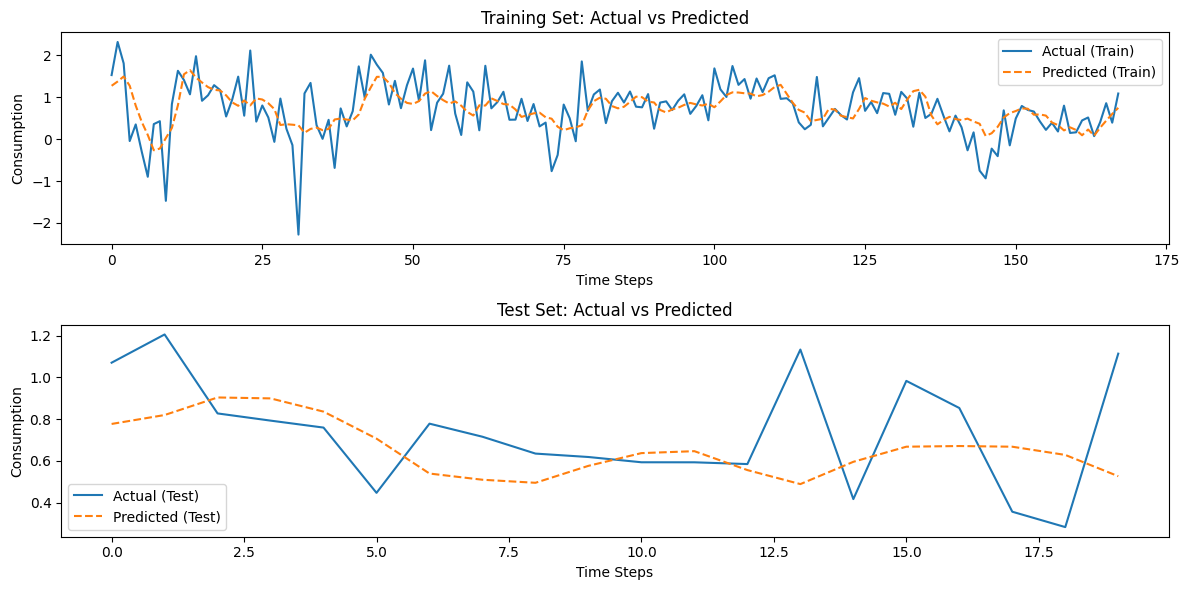

In [465]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

# Plot training data
plt.subplot(2, 1, 1)
plt.plot(y_train_rescaled, label="Actual (Train)")
plt.plot(y_train_pred_rescaled, label="Predicted (Train)", linestyle="--")
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Consumption")
plt.legend()

# Plot test data
plt.subplot(2, 1, 2)
plt.plot(y_test_rescaled, label="Actual (Test)")
plt.plot(y_pred_rescaled, label="Predicted (Test)", linestyle="--")
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Consumption")
plt.legend()

plt.tight_layout()
plt.show()


In [469]:
df["Consumption"]

0      0.618566
1      0.451984
2      0.872872
3     -0.271848
4      1.901345
         ...   
193    0.983112
194    0.853181
195    0.356512
196    0.282885
197    1.113517
Name: Consumption, Length: 198, dtype: float64

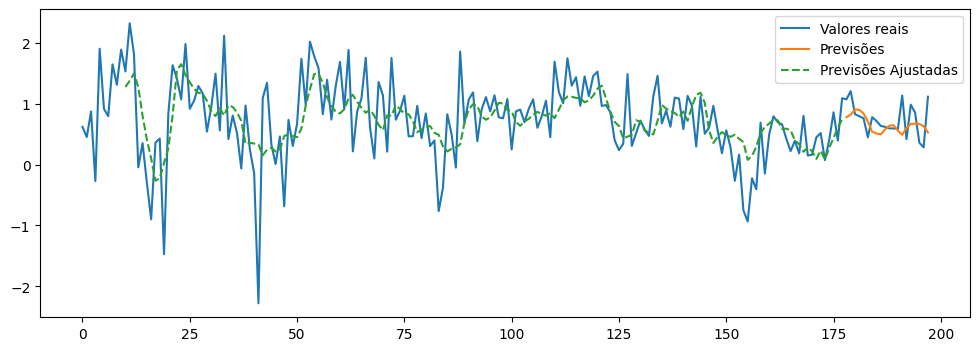

In [472]:
forecast_index = range(len(df["Consumption"]) - 20, len(df["Consumption"]) )
fitted_index = range(10 ,len(df["Consumption"]) - 20 )
plt.figure(figsize=(12, 4))
plt.plot(df["Consumption"], label="Valores reais")
plt.plot(forecast_index, y_pred_rescaled, label="Previsões")
plt.plot(fitted_index, y_train_pred_rescaled, label="Previsões Ajustadas", linestyle="--")
# Plot true values (in-sample)

# plt.fill_between(forecast_index, 
#                  conf_interval_sarimax[:, 0], 
#                  conf_interval_sarimax[:, 1], 
#                  color='pink', 
#                  alpha=0.3, 
#                  label="Intervalo de Confiança")
plt.legend()
plt.show()

In [466]:
upper_bound, lower_bound

(array([0.77688334, 0.81958618, 0.90369325, 0.89926965, 0.835911  ,
        0.70655156, 0.53934173, 0.50963923, 0.49505118, 0.57624782,
        0.63719174, 0.64649575, 0.55591345, 0.48878777, 0.59555213,
        0.66788759, 0.67110931, 0.66784374, 0.62853389, 0.52658801]),
 array([0.77688334, 0.81958618, 0.90369325, 0.89926965, 0.835911  ,
        0.70655156, 0.53934173, 0.50963923, 0.49505118, 0.57624782,
        0.63719174, 0.64649575, 0.55591345, 0.48878777, 0.59555213,
        0.66788759, 0.67110931, 0.66784374, 0.62853389, 0.52658801]))

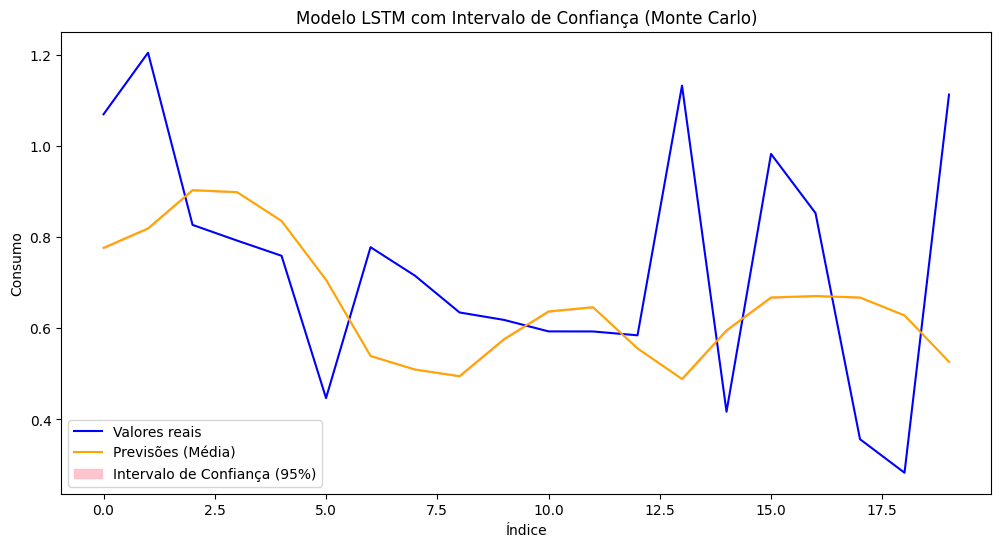

In [467]:
# Plot with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Valores reais", color="blue")
plt.plot(mean_prediction, label="Previsões (Média)", color="orange")
plt.fill_between(range(len(mean_prediction)), lower_bound, upper_bound, color="pink", alpha=0.93, label="Intervalo de Confiança (95%)")
plt.title("Modelo LSTM com Intervalo de Confiança (Monte Carlo)")
plt.xlabel("Índice")
plt.ylabel("Consumo")
plt.legend()
plt.show()